In [2]:
import numpy as np
import pandas as pd

import scanpy as sc
import muon as mu
from muon import atac as ac

import seaborn as sns 
import matplotlib.pyplot as plt

import os
import scipy.io

/home/annac/mambaforge/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/annac/mambaforge/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/annac/mambaforge/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarni

In [3]:
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sns.set(rc={"figure.figsize": (6, 6), "figure.dpi": 400})
sns.set_style("whitegrid")

sc.settings.autosave = False
sc.settings.set_figure_params(dpi_save=480, format="png")

## Reading data

we will read everything with muon but then select only atac seq modality 

In [4]:
path = '/home/annac/datasets/lymphoma_10x/lymph_node_lymphoma_14k_filtered_feature_bc_matrix.h5'
path_fragments = '/home/annac/datasets/lymphoma_10x/lymph_node_lymphoma_14k_atac_fragments.tsv.gz'

In [5]:
# path checks
if path[-2:] != 'h5':
    raise TypeError('Check that the matrix is in the h5 format!')
if 'filtered' in path:
    mode = 'filtered'
elif 'raw' in path:
    mode = 'raw'
else:
    mode = input('Type in your dataset type: filteres of raw?')

# loading the data
mdata = mu.read_10x_h5(path)

# locating fragments
mu.atac.tl.locate_fragments(mdata, path_fragments)

/home/annac/mambaforge/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /home/annac/datasets/lymphoma_10x/lymph_node_lymphoma_14k_filtered_feature_bc_matrix.h5


/home/annac/mambaforge/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/annac/mambaforge/lib/python3.8/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/home/annac/mambaforge/lib/python3.8/site-packages/mudata/_core/mudata.py:710: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/annac/mambaforge/lib/python3.8/site-packages/mudata/_core/mudata.py:710: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. T

In [6]:
mdata

MuData object with n_obs × n_vars = 14566 × 146390
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	14566 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	14566 x 109789
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'files'

In [7]:
# selecting the ATAC seq modality 
if 'atac' in mdata.mod.keys():
        atac = mdata.mod['atac']
elif 'ATAC' in mdata.mod.keys():
    atac = mdata.mod['ATAC']
else:
    raise TypeError('Check that your matrix contains ATAC modality!')

# calculate metrix
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

/home/annac/mambaforge/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


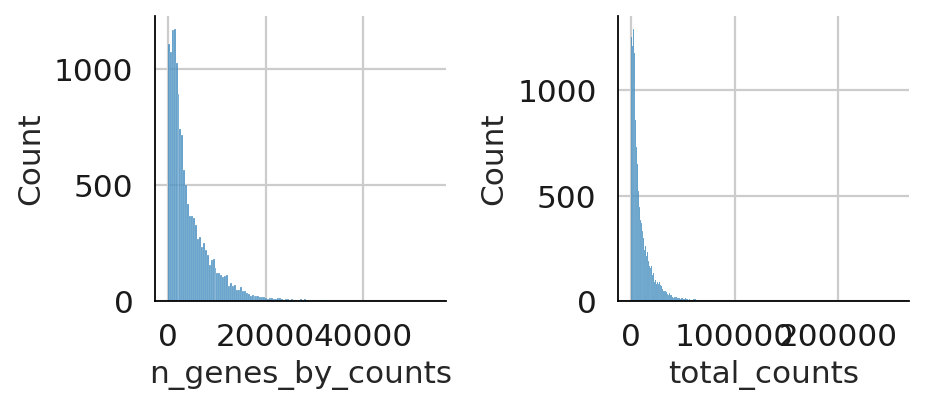

In [8]:
mu.pl.histogram(atac, ["n_genes_by_counts", "total_counts"])

In [9]:
atac

AnnData object with n_obs × n_vars = 14566 × 109789
    obs: 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'files'

In [12]:
mode = "raw"

In [13]:
def preprocessing_raw(atac, n_cells_min = 10, n_peaks_min = 100, n_peaks_max = 15000,
                     totalc_min = 2000, totalc_max = 60000, 
                     ns_threshold = 2, tss_threshold = 1.5):
    '''
    atac - AnnData object
    Returns: 
    atac - AnnData object, filtered 
    '''    
    # gene counts, cell counts FILTERING
    mu.pp.filter_var(atac, "n_cells_by_counts", lambda x: x >= n_cells_min)
    mu.pp.filter_obs(atac, "n_genes_by_counts", lambda x: (x >= n_peaks_min) & (x <= n_peaks_max)) # number of peaks > 0 per barcode
    mu.pp.filter_obs(atac, "total_counts", lambda x: (x >= totalc_min) & (x <= totalc_max))
    
    # gene counts, cell counts PLOTTING
    sc.pl.violin(atac, ["total_counts", "n_genes_by_counts"], jitter=0.4, multi_panel=True)
    mu.pl.histogram(atac, ["n_genes_by_counts", "total_counts"])

    # NS FILTERING
    atac.obs["NS"] = 1
    # adding the nucleosome signal
    ac.tl.nucleosome_signal(atac, n=1e6)
    mu.pp.filter_obs(atac, "nucleosome_signal", lambda x: x <= ns_threshold)

    # TSS FILTERING - WE NEED RNA DATA FOR THIS TO FETCH GENES
    ac.tl.tss_enrichment(mdata, n_tss=3000, random_state=666)
    mu.pp.filter_obs(atac, "tss_score", lambda x: x >= tss_threshold)

/home/annac/mambaforge/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


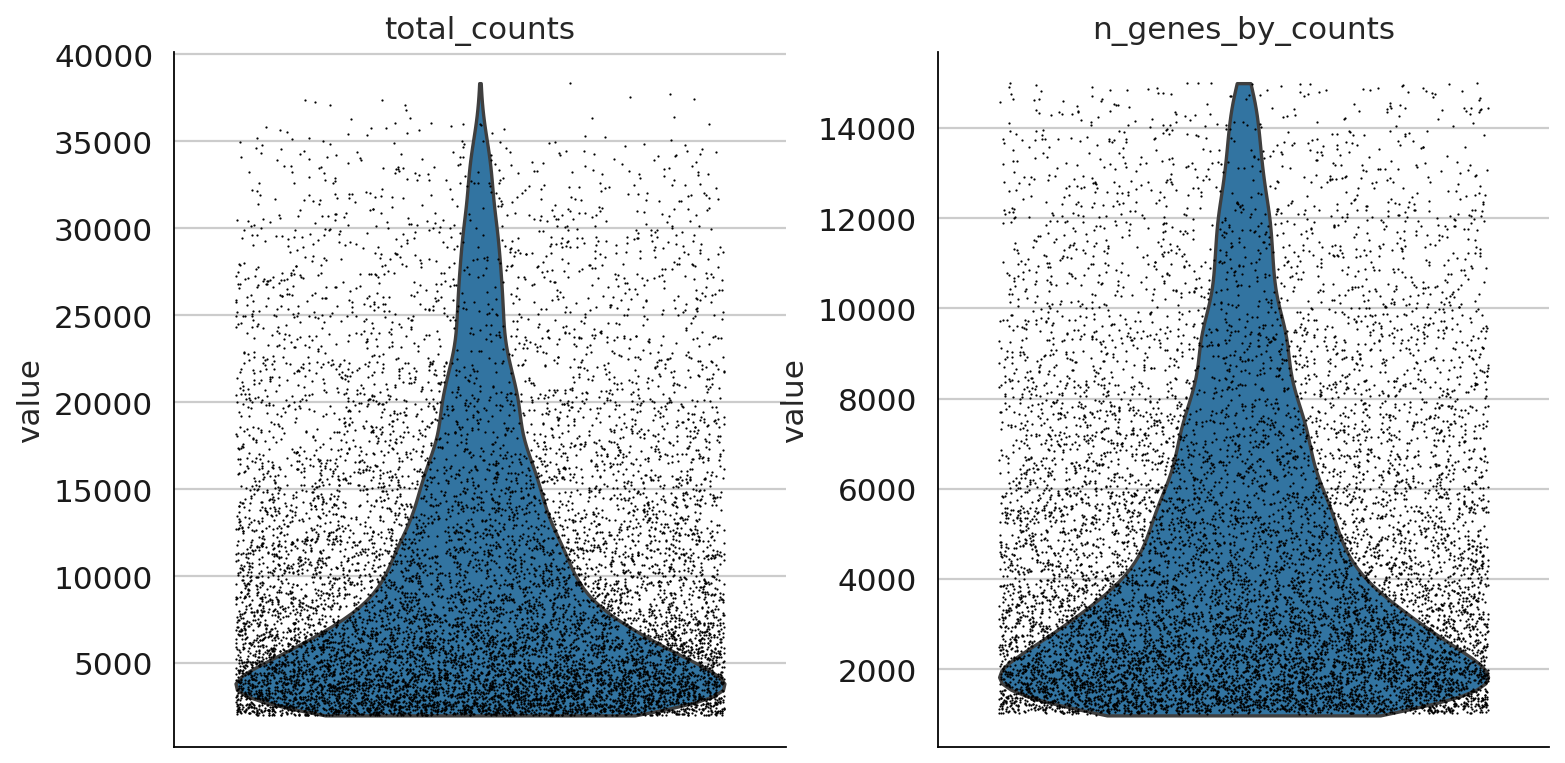

/home/annac/mambaforge/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


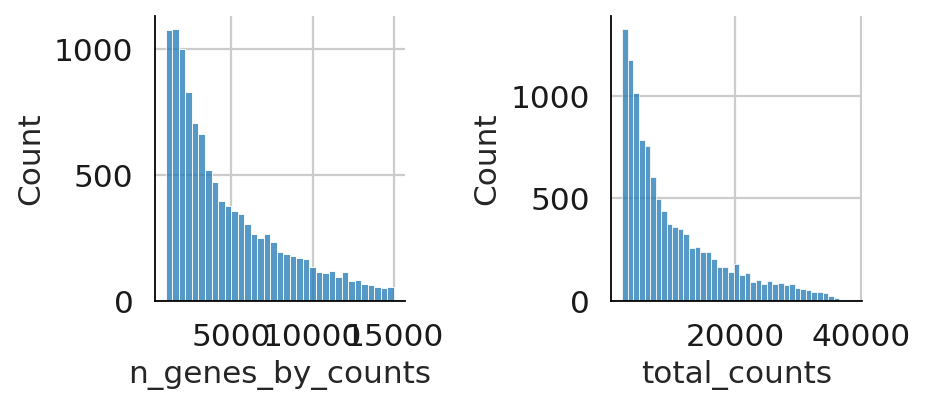

Fetching Regions...: 100%|██████████████████| 3000/3000 [00:51<00:00, 57.82it/s]


In [14]:
# if we have raw data - we will filter it
if mode == 'raw':
    preprocessing_raw(atac)

# if we have already filtered data - we will 
#sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)
#sc.pl.violin(atac, ["total_counts", "n_genes_by_counts"], jitter=0.4, multi_panel=True)

In [ ]:
def preprocessing_filtered(atac):
    '''
    atac - AnnData object, filtered
    Returns: 
    atac - AnnData object, filtered 
    '''
    

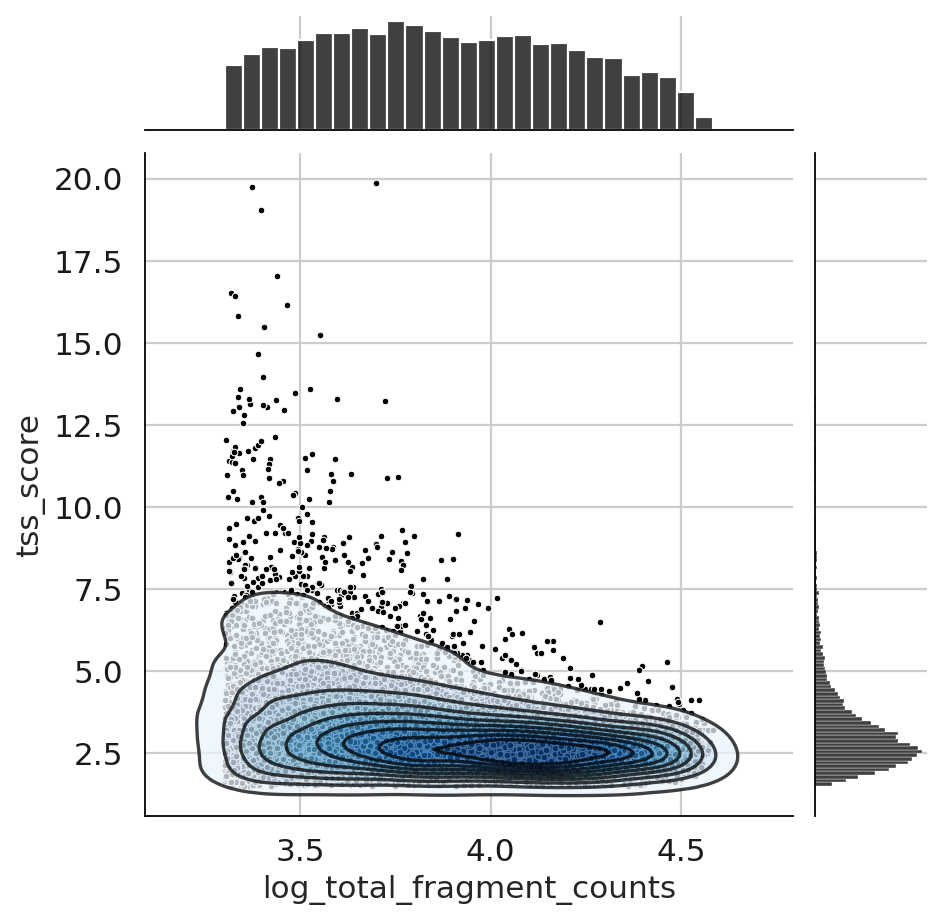

In [19]:
plot_tss_max = 20
atac.obs["log_total_fragment_counts"] = np.log10(atac.obs["total_counts"])

g = sns.jointplot(
    data=atac[(atac.obs["tss_score"] < plot_tss_max)].obs,
    x="log_total_fragment_counts",
    y="tss_score",
    color="black",
    marker=".",
)
# Density plot including lines
g.plot_joint(sns.kdeplot, fill=True, cmap="Blues", zorder=1, alpha=0.75)
g.plot_joint(sns.kdeplot, color="black", zorder=2, alpha=0.75)

# Lines thresholds
#plt.axvline(x=np.log10(count_cutoff_lower), c="red")
#plt.axvline(x=np.log10(lcount_cutoff_upper), c="red")
#plt.axhline(y=1.5, c="red")

plt.show()

In [20]:
mdata.update_obs()
output_dir = '/home/annac/datasets/lymphoma_10x/'
mdata.write("{d}/lymphoma_filtered_withQC.h5mu".format(d=output_dir))

/home/annac/mambaforge/lib/python3.8/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/home/annac/mambaforge/lib/python3.8/site-packages/mudata/_core/mudata.py:710: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/annac/mambaforge/lib/python3.8/site-packages/mudata/_core/mudata.py:710: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
